<a href="https://colab.research.google.com/github/neeti098/Abandoned_Cart_Audience_Segmentation/blob/main/Abandoned_Cart_Audience_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random


In [2]:
np.random.seed(42)
n = 50000
today = datetime.today()

data = pd.DataFrame({
    "user_id": np.arange(1, n+1),
    "cart_abandoned_date": np.random.choice(
        [today - timedelta(days=i) for i in range(0,15)], n),
    "last_order_date": np.random.choice(
        [today - timedelta(days=i) for i in range(0,60)], n),
    "avg_order_value": np.random.randint(100, 5000, n),
    "sessions_last_30d": np.random.randint(1, 50, n),
    "num_cart_items": np.random.randint(1, 15, n),
    "engagement_score": np.round(np.random.rand(n), 2),
    "profitability_score": np.round(np.random.rand(n), 2)
})
data.head()


,user_id,cart_abandoned_date,last_order_date,avg_order_value,sessions_last_30d,num_cart_items,engagement_score,profitability_score
0,1,2025-09-09 08:19:54.895502,2025-09-12 08:19:54.895502,3668,41,9,0.54,0.16
1,2,2025-09-12 08:19:54.895502,2025-08-24 08:19:54.895502,4523,17,2,0.15,0.38
2,3,2025-09-03 08:19:54.895502,2025-08-24 08:19:54.895502,4912,13,5,0.20,0.14
3,4,2025-09-01 08:19:54.895502,2025-07-29 08:19:54.895502,4086,30,14,0.03,0.42
4,5,2025-09-05 08:19:54.895502,2025-07-21 08:19:54.895502,3276,26,4,0.73,0.10


In [3]:
universe = data[data["cart_abandoned_date"] >= today - timedelta(days=7)]
print("Universe Size:", len(universe))


Universe Size: 26629


In [4]:
def segment_users(df):
    conditions = [
        (df["avg_order_value"] > 3000),
        ((df["avg_order_value"] > 1000) & (df["avg_order_value"] <= 3000) & (df["engagement_score"] > 0.5)),
        (df["profitability_score"] > 0.7),
    ]
    choices = ["High AOV Abandoners", "Mid AOV Engaged", "High Profitability"]
    df["segment"] = np.select(conditions, choices, default="Other Bucket")
    return df

universe = segment_users(universe)
universe["segment"].value_counts()


/tmp/ipython-input-892536293.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["segment"] = np.select(conditions, choices, default="Other Bucket")


,count
segment,
High AOV Abandoners,10872
Other Bucket,7298
Mid AOV Engaged,5353
High Profitability,3106


In [5]:
min_size, max_size = 500, 20000

seg_counts = universe["segment"].value_counts().to_dict()

def enforce_constraints(df):
    valid_segments = []
    for seg, count in seg_counts.items():
        if min_size <= count <= max_size:
            valid_segments.append(seg)
        else:
            df.loc[df["segment"] == seg, "segment"] = "Other Bucket"
    return df

universe = enforce_constraints(universe)
universe["segment"].value_counts()


,count
segment,
High AOV Abandoners,10872
Other Bucket,7298
Mid AOV Engaged,5353
High Profitability,3106


In [6]:
def compute_scores(df):
    df_grouped = df.groupby("segment").agg(
        size=("user_id", "count"),
        avg_engagement=("engagement_score", "mean"),
        avg_profit=("profitability_score", "mean"),
        avg_aov=("avg_order_value", "mean")
    ).reset_index()

    df_grouped["conversion_potential"] = (
        df_grouped["avg_engagement"] * (1 / (df_grouped["avg_aov"].rank()))
    )
    df_grouped["lift_vs_control"] = np.random.rand(len(df_grouped))
    df_grouped["size_norm"] = df_grouped["size"] / df_grouped["size"].max()
    df_grouped["strategic_fit"] = (df_grouped["avg_profit"] + df_grouped["avg_engagement"]) / 2
    df_grouped["overall_score"] = (
        0.3*df_grouped["conversion_potential"] +
        0.2*df_grouped["lift_vs_control"] +
        0.2*df_grouped["size_norm"] +
        0.3*df_grouped["strategic_fit"]
    )
    df_grouped["valid"] = df_grouped["size"].between(min_size, max_size)
    return df_grouped

results = compute_scores(universe)
results


,segment,size,avg_engagement,avg_profit,avg_aov,conversion_potential,lift_vs_control,size_norm,strategic_fit,overall_score,valid
0,High AOV Abandoners,10872,0.495225,0.500946,3997.633186,0.123806,0.636438,1.000000,0.498085,0.513855,True
1,High Profitability,3106,0.367746,0.856590,1316.060528,0.183873,0.889917,0.285688,0.612168,0.473934,True
2,Mid AOV Engaged,5353,0.753264,0.504915,2003.266019,0.251088,0.798995,0.492366,0.629089,0.522325,True
3,Other Bucket,7298,0.370902,0.350528,1314.574952,0.370902,0.823183,0.671266,0.360715,0.518375,True


In [7]:
results.to_csv("segmentation_strategy.csv", index=False)
results.to_json("segmentation_strategy.json", orient="records")
print("Files saved")


Files saved


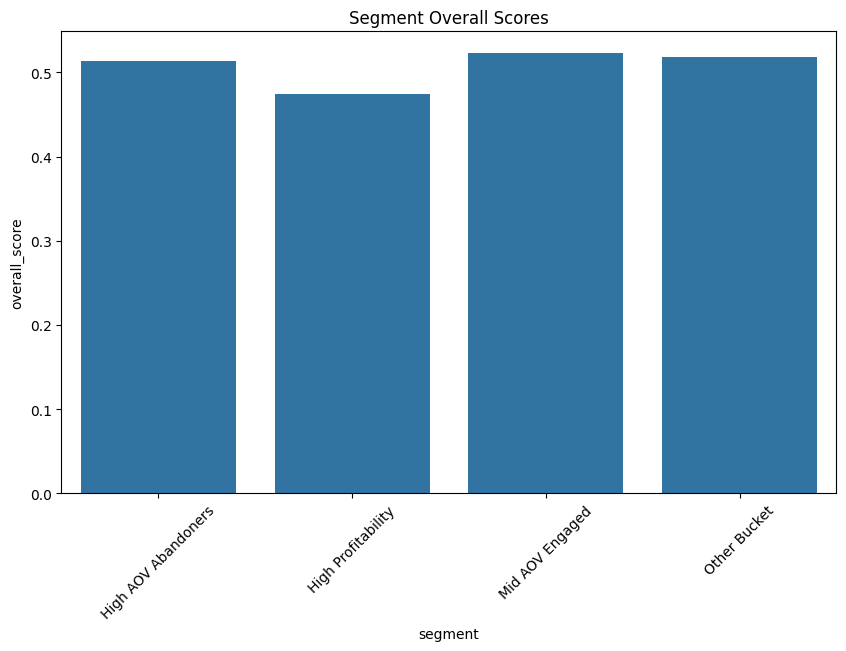

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x="segment", y="overall_score", data=results)
plt.title("Segment Overall Scores")
plt.xticks(rotation=45)
plt.show()


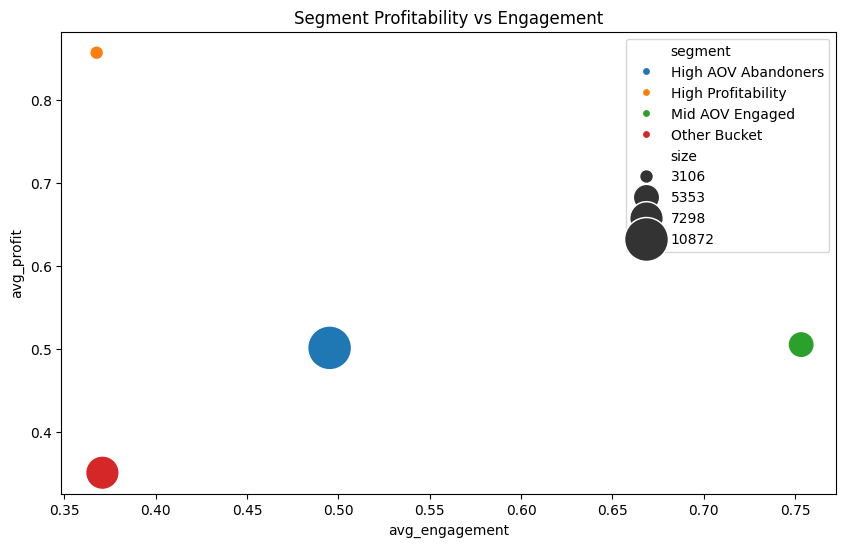

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="avg_engagement", y="avg_profit", size="size", hue="segment", data=results, sizes=(100,1000))
plt.title("Segment Profitability vs Engagement")
plt.show()
